<a href="https://colab.research.google.com/github/valeromora/TAM_2025-1/blob/main/talleres_corte2/Copia_de_6_CVClasificacion_LFW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación multiclase - comparación de métodos utilizando validación cruzada

- Se presenta un esquema completo de comparación de clasifacadores en la base de datos People Labaled Faces in the Wild, aka Labeled Faces in the Wild ([LFW](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html)).

- Además, se plantean algunos ejercicios teórico-prácticos relacionados con tareas de clasificación utilizando aprendizaje de máquina clásico.

- Se plantean algunas funciones para el cálculo de curvas ROC, medidas de rendimiento y gráficas básicas

In [1]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Lectura base de datos LFW

- Se carga la base de datos desde los repositorios de sklearn.

Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


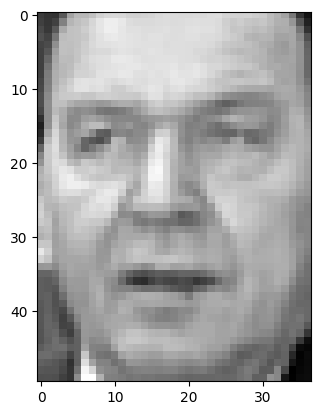

In [2]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

# HoldOut evaluación

- Se particiona el conjunto de datos en 70% para entrenamiento y 30% para evaluación.

In [3]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


# Búsqueda de parámetros utilizando gridsearchCV

**Nota**: Recuerde que GridsearchCV utiliza validación cruzada para encontrar los mejores hiperparámetros según los rendimientos promedios en el conjunto de test (validación si se considera la partición original)


![cv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/grid_search_cross_validation.png?raw=1)

In [4]:
#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


# Rendimientos utilizando validación cruzada (conjuntos entrenamiento y validación)

- Se muestran los resultados de la validación cruzada para los mejores modelos encontrados en el gridsearch

- Para utilizar distintos scores de entrenamiento en clasificación ver [https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

**Nota**: el argumento `refit=True` en GridsearchCV asegura reentrenar el mejor modelo encontrado utilizando toda la base de datos, pensando en generalizar bien sobre el conjunto de test.

In [5]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

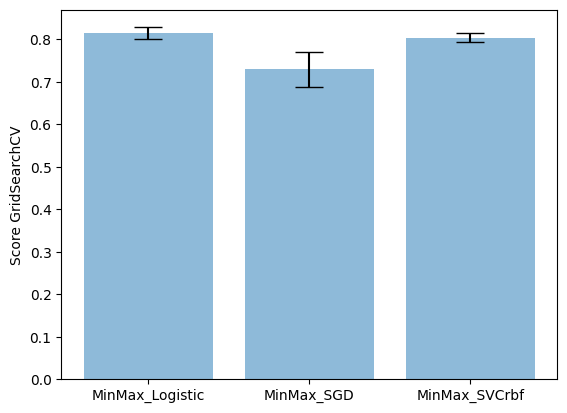

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.729 0.804]
 [0.014 0.041 0.011]]


In [6]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

# Calcular rendimiento en cojunto de test

- En caso práctico y buscando cuantificar la generalización de los modelos, se cálcula el rendimiento sobre el conjunto de test original.

- Se presentan las matrices de confusión y se utiliza el método [`classification report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) de sklearn para calcular las medidas de acierto, precision, exhaustividad, f1.

**Nota**: Es importante tener en cuenta que los resultados de comparación incluyen promediados simples, sopesados en términos de la probabilidad marginal de cada clase, además de promediados [micro y macro](https://www.educative.io/answers/what-is-the-difference-between-micro-and-macro-averaging).

Evaluando modelo MinMax_Logistic (1/3)


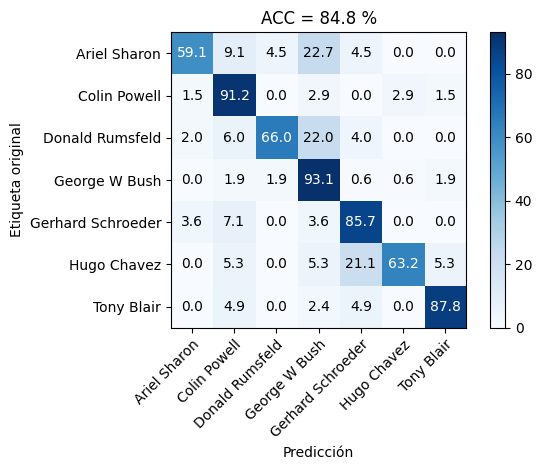

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


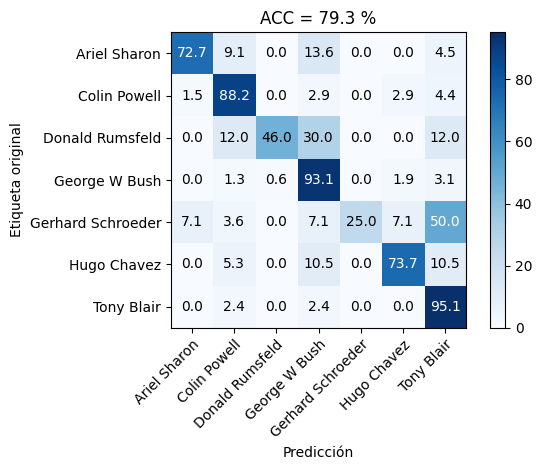

                   precision    recall  f1-score   support

     Ariel Sharon       0.84      0.73      0.78        22
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.96      0.46      0.62        50
    George W Bush       0.86      0.93      0.89       159
Gerhard Schroeder       1.00      0.25      0.40        28
      Hugo Chavez       0.67      0.74      0.70        19
       Tony Blair       0.56      0.95      0.70        41

         accuracy                           0.79       387
        macro avg       0.81      0.71      0.71       387
     weighted avg       0.83      0.79      0.78       387

Evaluando modelo MinMax_SVCrbf (3/3)


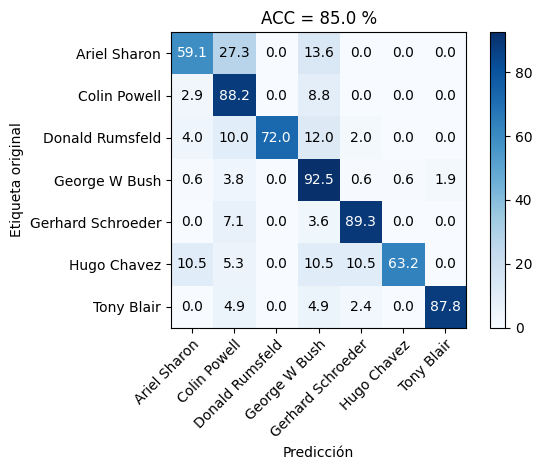

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [7]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)


## Curva ROC multiclase - sobre conjunto de test

- Finalmente, se presentan las curvas ROC multiclase.

**Nota**: Se debe ajustar la líne de código donde se cálcula el score de predicción en términos de la función de decisión (decision_function) o la probilidad de la predicción (predict_proba), según el tipo de modelo.

Por ejemplo: la  [´SVC´](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) utiliza el método decision function, el [´KnearestNeighborsClassifier´](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) utiliza el método predict proba.

Evaluando modelo MinMax_Logistic (1/3)


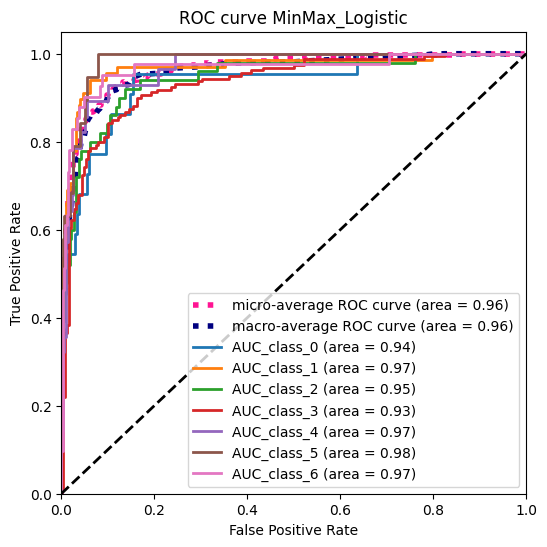

Evaluando modelo MinMax_SGD (2/3)


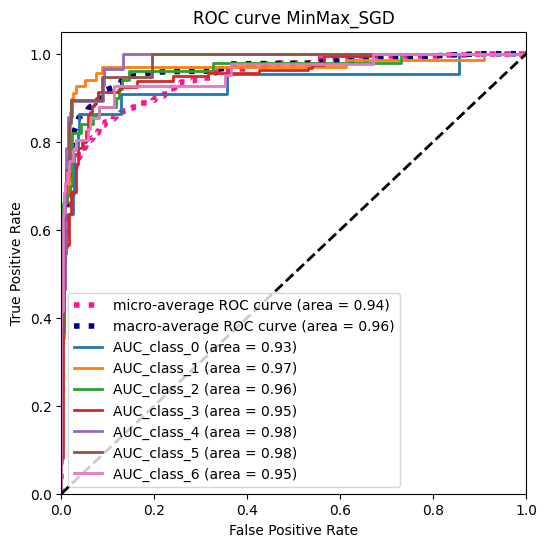

Evaluando modelo MinMax_SVCrbf (3/3)


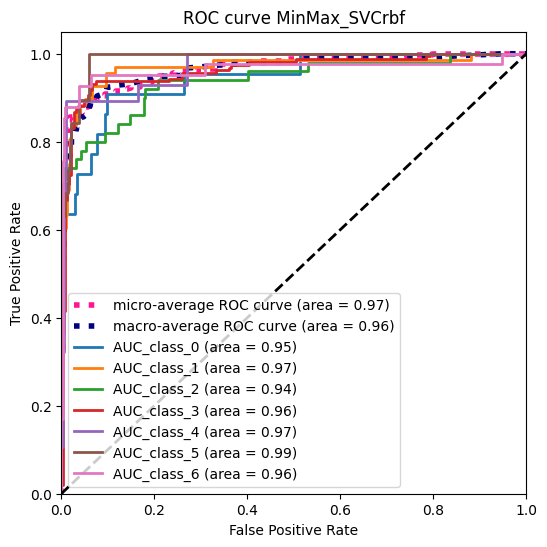

In [8]:
from sklearn.preprocessing import label_binarize

ytrain_b = label_binarize(ytrain, classes=range(lfw_people.target_names.shape[0]))
ytest_b = label_binarize(ytest, classes=range(lfw_people.target_names.shape[0]))

for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))
    #debe calcularse la funcion de decision o el posterior de la probabilidad
    ytest_score = my_model_loaded[i].decision_function(Xtest)
    roc_auc, fpr, tpr, n_classes = roc_multiclass(ytest_b,ytest_score)
    roc_auc_mc(roc_auc,fpr,tpr,n_classes,'ROC curve ' + label_models[i],path_img)


# Ejercicio

1. Consulte y presente el modelo y problema de optimización de los siguientes clasificadores:

- [Naive_Bayes.GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

2. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento, compare el rendimiento de los métodos del punto 1. Emplee optimización Bayesiana de hiperparámetros, fijando el score en términos del acc, el f1 y el AUC.


In [10]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
from sklearn.naive_bayes import GaussianNB
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

# Naive_Bayes.GaussianNB

In [12]:
# Pipeline
pipe_nb = Pipeline([
    ('scaler', MinMaxScaler()),
    ('nb', GaussianNB())
])

# Espacio de hiperparámetros para GaussianNB
param_space_nb = {
    'nb__var_smoothing': (1e-11, 1e-7, 'log-uniform')
}

# Búsqueda bayesiana
opt_nb = BayesSearchCV(
    pipe_nb,
    param_space_nb,
    n_iter=20,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted', 'auc': 'roc_auc_ovr'},
    refit='acc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenar
opt_nb.fit(Xtrain, ytrain)
print("Mejores hiperparámetros:", opt_nb.best_params_)
print("Mejor accuracy CV:", opt_nb.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [13]:
import joblib
joblib.dump(opt_nb, "results/model_nb_bayes.pkl")

['results/model_nb_bayes.pkl']

Accuracy en test: 40.31%


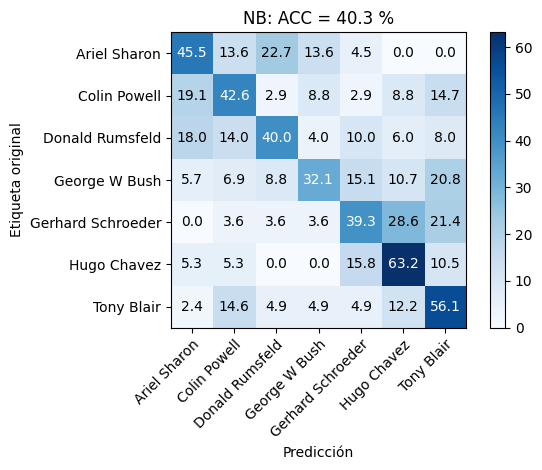

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387



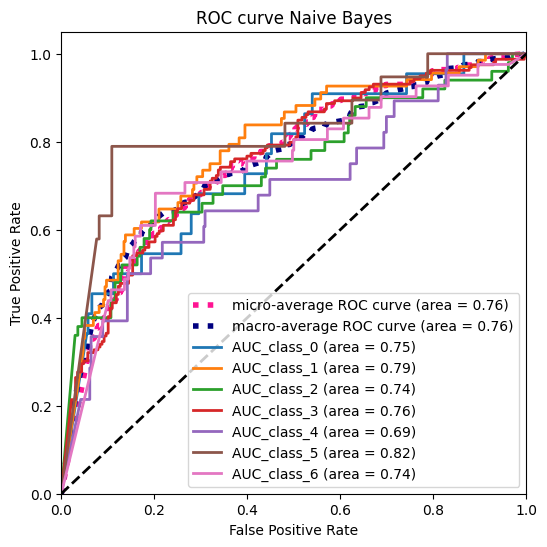

In [14]:
# Cargar modelo entrenado
nb_model = joblib.load("results/model_nb_bayes.pkl")

# Predicción
ytest_pred_nb = nb_model.best_estimator_.predict(Xtest)

# Evaluación general
acc_nb = accuracy_score(ytest, ytest_pred_nb)
print("Accuracy en test: %.2f%%" % (acc_nb * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_nb,
    classes=lfw_people.target_names,
    title='NB: ACC = %.1f %%' % (100*acc_nb)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_nb,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
ytest_score_nb = nb_model.best_estimator_.predict_proba(Xtest)
roc_auc_nb, fpr_nb, tpr_nb, n_classes = roc_multiclass(ytest_b, ytest_score_nb)
roc_auc_mc(roc_auc_nb, fpr_nb, tpr_nb, n_classes, 'ROC curve Naive Bayes', path_img)

# SGDClassifier

In [33]:
from sklearn.impute import SimpleImputer

# Pipeline
pipe_sgd = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('clf', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])

# Espacio de búsqueda bayesiana
param_space_sgd = {
    'clf__alpha': (1e-6, 1e-1, 'log-uniform'),
    'clf__loss': ['log_loss', 'modified_huber'], #'hinge'
    'clf__penalty': ['l2', 'l1', 'elasticnet']
}

# BayesSearchCV
opt_sgd = BayesSearchCV(
    pipe_sgd,
    param_space_sgd,
    n_iter=30,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted'},#, 'auc': 'roc_auc_ovr'},
    refit='acc', #'auc' 'f1'
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)
print("NaNs en Xtrain:", np.isnan(Xtrain).sum())
print("NaNs en ytrain:", pd.isnull(ytrain).sum())

# Entrenamiento
opt_sgd.fit(Xtrain, ytrain)
print("Mejores hiperparámetros:", opt_sgd.best_params_)
print("Mejor accuracy CV:", opt_sgd.best_score_)

NaNs en Xtrain: 0
NaNs en ytrain: 0
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for 

In [34]:
joblib.dump(opt_sgd, "results/model_sgd_bayes.pkl")

['results/model_sgd_bayes.pkl']

Accuracy en test: 83.72%


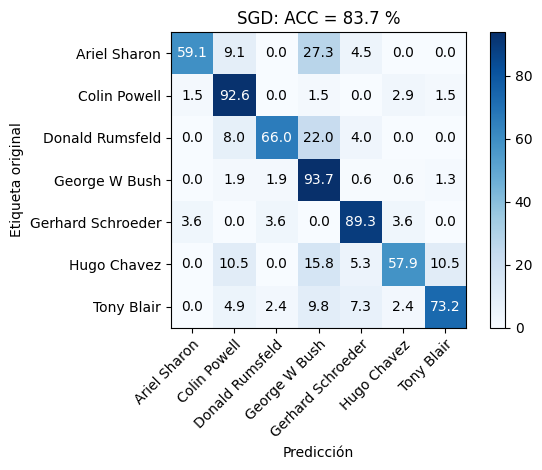

                   precision    recall  f1-score   support

     Ariel Sharon       0.87      0.59      0.70        22
     Colin Powell       0.83      0.93      0.88        68
  Donald Rumsfeld       0.87      0.66      0.75        50
    George W Bush       0.86      0.94      0.89       159
Gerhard Schroeder       0.76      0.89      0.82        28
      Hugo Chavez       0.69      0.58      0.63        19
       Tony Blair       0.86      0.73      0.79        41

         accuracy                           0.84       387
        macro avg       0.82      0.76      0.78       387
     weighted avg       0.84      0.84      0.83       387



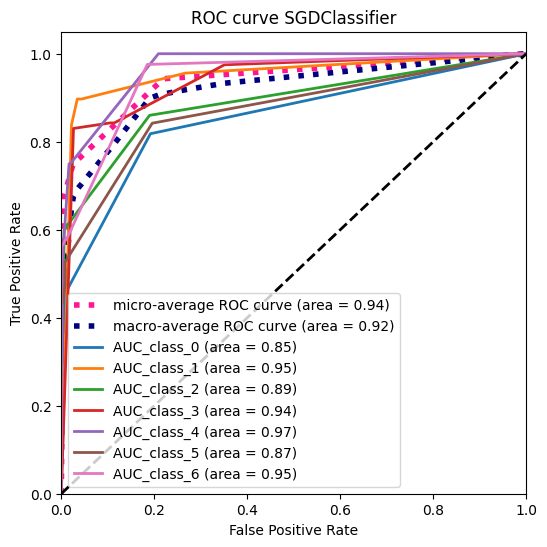

In [35]:
# Cargar modelo
sgd_model = joblib.load("results/model_sgd_bayes.pkl")

# Predicción
ytest_pred_sgd = sgd_model.best_estimator_.predict(Xtest)
acc_sgd = accuracy_score(ytest, ytest_pred_sgd)
print("Accuracy en test: %.2f%%" % (acc_sgd * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_sgd,
    classes=lfw_people.target_names,
    title='SGD: ACC = %.1f %%' % (100*acc_sgd)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_sgd,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
# Para SGDClassifier con `log_loss`, podemos usar predict_proba; si es `hinge` (SVM), usamos decision_function
if hasattr(sgd_model.best_estimator_['clf'], 'predict_proba'):
    ytest_score_sgd = sgd_model.best_estimator_.predict_proba(Xtest)
else:
    ytest_score_sgd = sgd_model.best_estimator_.decision_function(Xtest)

# ROC multiclass
roc_auc_sgd, fpr_sgd, tpr_sgd, n_classes = roc_multiclass(ytest_b, ytest_score_sgd)
roc_auc_mc(roc_auc_sgd, fpr_sgd, tpr_sgd, n_classes, 'ROC curve SGDClassifier', path_img)


# LogisticRegression

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Pipeline
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('clf', LogisticRegression(max_iter=1000, solver='saga', random_state=42))
])

# Espacio de búsqueda
param_space_lr = {
    'clf__C': (1e-4, 1e2, 'log-uniform'),
    'clf__penalty': ['l1', 'l2', 'elasticnet'],
    'clf__l1_ratio': (0.0, 1.0)  # solo usado cuando penalty='elasticnet'
}

# Búsqueda Bayesiana
opt_lr = BayesSearchCV(
    pipe_lr,
    param_space_lr,
    n_iter=30,
    scoring={
        'acc': 'accuracy',
        'f1': 'f1_weighted',
        # evitamos 'auc' para evitar errores con clases múltiples o NaNs
    },
    refit='acc',  # puedes cambiar a 'f1' si te interesa más esa métrica
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenamiento
opt_lr.fit(Xtrain, ytrain)

# Resultados
print("Mejores hiperparámetros:", opt_lr.best_params_)
print("Mejor accuracy CV:", opt_lr.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [ ]:
# Guardar modelo optimizado
joblib.dump(opt_lr, "results/model_logreg_bayes.pkl")

In [ ]:
# Cargar modelo (opcional, útil si trabajas en otra sesión)
logreg_model = joblib.load("results/model_logreg_bayes.pkl")

# Predicción
ytest_pred_lr = logreg_model.best_estimator_.predict(Xtest)
acc_lr = accuracy_score(ytest, ytest_pred_lr)
print("Accuracy en test: %.2f%%" % (acc_lr * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_lr,
    classes=lfw_people.target_names,
    title='LogisticRegression: ACC = %.1f %%' % (100 * acc_lr)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_lr,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
ytest_score_lr = logreg_model.best_estimator_.predict_proba(Xtest)

# ROC multiclass
roc_auc_lr, fpr_lr, tpr_lr, n_classes = roc_multiclass(ytest_b, ytest_score_lr)
roc_auc_mc(roc_auc_lr, fpr_lr, tpr_lr, n_classes, 'ROC curve LogisticRegression', 'results/roc_logistic.png')

# LinearDiscriminantAnalysis

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Pipeline
pipe_lda = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('clf', LinearDiscriminantAnalysis())
])

# Espacio de búsqueda bayesiana
param_space_lda = {
    'clf__solver': ['svd', 'lsqr', 'eigen'],
    'clf__shrinkage': ['auto', None]  # shrinkage solo para 'lsqr' y 'eigen'
}

# BayesSearchCV
opt_lda = BayesSearchCV(
    pipe_lda,
    param_space_lda,
    n_iter=15,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted', 'auc': 'roc_auc_ovr'},
    refit='acc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenamiento
opt_lda.fit(Xtrain, ytrain)

print("Mejores hiperparámetros:", opt_lda.best_params_)
print("Mejor accuracy CV:", opt_lda.best_score_)

In [ ]:
# Guardar modelo
import joblib
joblib.dump(opt_lda, "results/model_lda_bayes.pkl")

In [ ]:
# Cargar modelo
lda_model = joblib.load("results/model_lda_bayes.pkl")

# Predicción
ytest_pred_lda = lda_model.best_estimator_.predict(Xtest)
acc_lda = accuracy_score(ytest, ytest_pred_lda)
print("Accuracy en test: %.2f%%" % (acc_lda * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_lda,
    classes=lfw_people.target_names,
    title='LDA: ACC = %.1f %%' % (100 * acc_lda)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_lda,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
ytest_score_lda = lda_model.best_estimator_.predict_proba(Xtest)

# ROC multiclass
roc_auc_lda, fpr_lda, tpr_lda, n_classes = roc_multiclass(ytest_b, ytest_score_lda)
roc_auc_mc(roc_auc_lda, fpr_lda, tpr_lda, n_classes, 'ROC curve LDA', 'results/roc_lda.png')

# KNeighborsClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Pipeline
pipe_knn = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('clf', KNeighborsClassifier())
])

# Espacio de búsqueda bayesiana
param_space_knn = {
    'clf__n_neighbors': (1, 30),
    'clf__weights': ['uniform', 'distance'],
    'clf__p': (1, 2)  # p=1: Manhattan, p=2: Euclídea
}

# BayesSearchCV
opt_knn = BayesSearchCV(
    pipe_knn,
    param_space_knn,
    n_iter=30,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted', 'auc': 'roc_auc_ovr'},
    refit='acc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenamiento
opt_knn.fit(Xtrain, ytrain)

print("Mejores hiperparámetros:", opt_knn.best_params_)
print("Mejor accuracy CV:", opt_knn.best_score_)

In [ ]:
# Guardar modelo
joblib.dump(opt_knn, "results/model_knn_bayes.pkl")

In [ ]:
# Cargar modelo
knn_model = joblib.load("results/model_knn_bayes.pkl")

# Predicción
ytest_pred_knn = knn_model.best_estimator_.predict(Xtest)
acc_knn = accuracy_score(ytest, ytest_pred_knn)
print("Accuracy en test: %.2f%%" % (acc_knn * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_knn,
    classes=lfw_people.target_names,
    title='KNN: ACC = %.1f %%' % (100 * acc_knn)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_knn,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
ytest_score_knn = knn_model.best_estimator_.predict_proba(Xtest)

# ROC multiclass
roc_auc_knn, fpr_knn, tpr_knn, n_classes = roc_multiclass(ytest_b, ytest_score_knn)
roc_auc_mc(roc_auc_knn, fpr_knn, tpr_knn, n_classes, 'ROC curve KNN', 'results/roc_knn.png')

# LinearSVC


In [ ]:
from sklearn.svm import LinearSVC

# Pipeline
pipe_lsvc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('clf', LinearSVC(random_state=42, max_iter=10000))
])

# Espacio de búsqueda bayesiana
param_space_lsvc = {
    'clf__C': (1e-3, 100.0, 'log-uniform'),
    'clf__penalty': ['l2'],
    'clf__loss': ['squared_hinge'],
    'clf__dual': [False]  # recomendado para n_samples > n_features
}

# BayesSearchCV
opt_lsvc = BayesSearchCV(
    pipe_lsvc,
    param_space_lsvc,
    n_iter=30,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted', 'auc': 'roc_auc_ovr'},
    refit='acc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenamiento
opt_lsvc.fit(Xtrain, ytrain)

print("Mejores hiperparámetros:", opt_lsvc.best_params_)
print("Mejor accuracy CV:", opt_lsvc.best_score_)

In [ ]:
# Guardar modelo
joblib.dump(opt_lsvc, "results/model_lsvc_bayes.pkl")

In [ ]:
# Cargar modelo
lsvc_model = joblib.load("results/model_lsvc_bayes.pkl")

# Predicción
ytest_pred_lsvc = lsvc_model.best_estimator_.predict(Xtest)
acc_lsvc = accuracy_score(ytest, ytest_pred_lsvc)
print("Accuracy en test: %.2f%%" % (acc_lsvc * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_lsvc,
    classes=lfw_people.target_names,
    title='LinearSVC: ACC = %.1f %%' % (100 * acc_lsvc)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_lsvc,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# ROC multiclass (usamos decision_function porque no tiene predict_proba)
ytest_score_lsvc = lsvc_model.best_estimator_.decision_function(Xtest)

# ROC
roc_auc_lsvc, fpr_lsvc, tpr_lsvc, n_classes = roc_multiclass(ytest_b, ytest_score_lsvc)
roc_auc_mc(roc_auc_lsvc, fpr_lsvc, tpr_lsvc, n_classes, 'ROC curve LinearSVC', 'results/roc_lsvc.png')

# SVC

In [ ]:
from sklearn.svm import SVC

# Pipeline
pipe_svc = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('clf', SVC(random_state=42, probability=True))
])

# Espacio de búsqueda bayesiana
param_space_svc = {
    'clf__C': (1e-3, 100.0, 'log-uniform'),
    'clf__gamma': (1e-4, 1.0, 'log-uniform'),  # solo si usamos RBF
    'clf__kernel': ['rbf', 'poly', 'sigmoid']
}

# BayesSearchCV
opt_svc = BayesSearchCV(
    pipe_svc,
    param_space_svc,
    n_iter=30,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted', 'auc': 'roc_auc_ovr'},
    refit='acc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenamiento
opt_svc.fit(Xtrain, ytrain)

print("Mejores hiperparámetros:", opt_svc.best_params_)
print("Mejor accuracy CV:", opt_svc.best_score_)

In [ ]:
# Guardar modelo
joblib.dump(opt_svc, "results/model_svc_bayes.pkl")

In [ ]:
# Cargar modelo
svc_model = joblib.load("results/model_svc_bayes.pkl")

# Predicción
ytest_pred_svc = svc_model.best_estimator_.predict(Xtest)
acc_svc = accuracy_score(ytest, ytest_pred_svc)
print("Accuracy en test: %.2f%%" % (acc_svc * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_svc,
    classes=lfw_people.target_names,
    title='SVC: ACC = %.1f %%' % (100 * acc_svc)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_svc,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
ytest_score_svc = svc_model.best_estimator_.predict_proba(Xtest)

# ROC multiclass
roc_auc_svc, fpr_svc, tpr_svc, n_classes = roc_multiclass(ytest_b, ytest_score_svc)
roc_auc_mc(roc_auc_svc, fpr_svc, tpr_svc, n_classes, 'ROC curve SVC', 'results/roc_svc.png')

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline
pipe_rf = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),  # aunque no es necesario para RF, lo dejamos por consistencia
    ('clf', RandomForestClassifier(random_state=42))
])

# Espacio de búsqueda
param_space_rf = {
    'clf__n_estimators': (50, 300),
    'clf__max_depth': (3, 30),
    'clf__min_samples_split': (2, 10),
    'clf__min_samples_leaf': (1, 10),
    'clf__max_features': ['sqrt', 'log2', None]
}

# BayesSearchCV
opt_rf = BayesSearchCV(
    pipe_rf,
    param_space_rf,
    n_iter=30,
    scoring={'acc': 'accuracy', 'f1': 'f1_weighted', 'auc': 'roc_auc_ovr'},
    refit='acc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Entrenamiento
opt_rf.fit(Xtrain, ytrain)

print("Mejores hiperparámetros:", opt_rf.best_params_)
print("Mejor accuracy CV:", opt_rf.best_score_)

In [ ]:
# Guardar modelo
joblib.dump(opt_rf, "results/model_rf_bayes.pkl")

In [ ]:
# Cargar modelo
rf_model = joblib.load("results/model_rf_bayes.pkl")

# Predicción
ytest_pred_rf = rf_model.best_estimator_.predict(Xtest)
acc_rf = accuracy_score(ytest, ytest_pred_rf)
print("Accuracy en test: %.2f%%" % (acc_rf * 100))

# Matriz de confusión
plot_confusion_matrix(
    ytest, ytest_pred_rf,
    classes=lfw_people.target_names,
    title='Random Forest: ACC = %.1f %%' % (100 * acc_rf)
)
plt.show()

# Reporte de clasificación
print(classification_report(
    ytest, ytest_pred_rf,
    labels=range(lfw_people.target_names.shape[0]),
    target_names=lfw_people.target_names
))

# Curva ROC
ytest_score_rf = rf_model.best_estimator_.predict_proba(Xtest)

# ROC multiclass
roc_auc_rf, fpr_rf, tpr_rf, n_classes = roc_multiclass(ytest_b, ytest_score_rf)
roc_auc_mc(roc_auc_rf, fpr_rf, tpr_rf, n_classes, 'ROC curve Random Forest', 'results/roc_rf.png')